# **CI Course - EX5**

--------

--------


## Theory Overview ##

**Fuzzy control systems:**

A fuzzy control system is a type of control system that uses fuzzy logic instead of traditional Boolean logic.<br/> It is particularly useful in situations where the input and output variables are not easily quantifiable or where the system being controlled is too complex for traditional methods.<br/> Fuzzy control systems are commonly used in a wide range of applications, from consumer electronics to industrial automation.

The components of a fuzzy control system include a fuzzifier, a knowledge base, an inference engine, a defuzzifier, and an output interface.


1. The **fuzzifier** converts the crisp input data into fuzzy sets, which can then be interpreted by the knowledge base.
2. The **Rule base** contains rules that relate the fuzzy input data to the desired fuzzy output data.
3. The **inference** engine applies these rules to the fuzzy input data and produces a fuzzy output.
4. The **defuzzifier** converts the fuzzy output into a crisp output that can be used to control the system.
5. The **output** interface communicates the crisp output to the system being controlled.

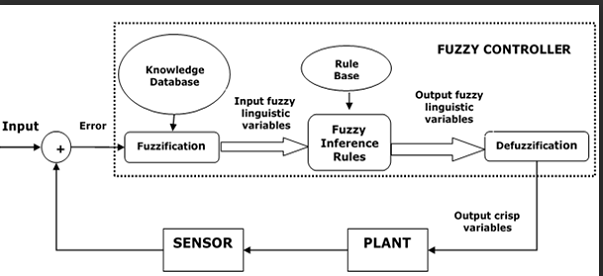!


---


### Exersice - fuzzy fan speed control ###

In this exercise, we will develop a fuzzy control system to control fan speed based on data obtained from temperature and humidity sensors.

There are three solution spaces (universes) : temperature[C], humidity[%], and speed[%], and each space is divided into multiple fuzzy sets with corresponding membership functions.

- The temperature space consists of 'Cold', 'Good', and 'Hot' sets, each with a Gaussian membership function.
- The humidity space consists of 'Dry', 'Acceptable', and 'Wet' sets, each with a triangular membership function.
- The speed space includes 'Low', 'Medium', and 'High' sets, each with a triangular membership function. 

**The goal** is to create a smart heating system that will command the fan to stabilize at a certain speed based on the temperature and humidity readings.

The inference system will be based on **3 rules**:
1. If the Temperature is Hot AND Humidity is Wet, then the fan is High (**2 conditions** with **AND** relation)
2. If the Humidity is Acceptable, then the fan is Medium (**1 condition**)
3. If the Temperature is Good OR the Humidity is Dry, then the fan will be Low (**2 conditions** with **OR** relation)


---


### Solution ###

#### Import libraries and "read" the sensors input ####


In [4]:
!pip install scikit-fuzzy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
%matplotlib inline

# What would the fan speed be in the following circumstance:
T = 28
H = 37

####  Defining the fuzzy sets and their corresponding membership functions ####

In [17]:
# Generate universe variables
#   * Temperature in the subjective range [-10, 50] degC
#   * Humidity in the subjective range [0, 100] percent
#   * Fan has a range of [0, 100] percent of speed
x_temp = np.arange(-10, 50, 1) 
x_humidity = np.arange(0, 100, 1) 
x_fan  = np.arange(0, 100, 1)

# Generate fuzzy membership functions
                        #(in array,mean,std)
temp_cold = fuzz.gaussmf(x_temp, 10, 5.5)
temp_good = fuzz.gaussmf(x_temp, 21, 5)
temp_hot = fuzz.gaussmf(x_temp, 33, 5.5)
                    #(in array,[left vertex ,center vertex, right vertex])
humid_dry = fuzz.trimf(x_humidity, [0, 0, 50])
humid_acceptable = fuzz.trimf(x_humidity, [20, 50, 80])
humid_wet = fuzz.trimf(x_humidity, [50, 100, 100])
fan_lo = fuzz.trimf(x_fan, [0, 0, 50])
fan_md = fuzz.trimf(x_fan, [0, 50, 100])
fan_hi = fuzz.trimf(x_fan, [50, 100, 100])

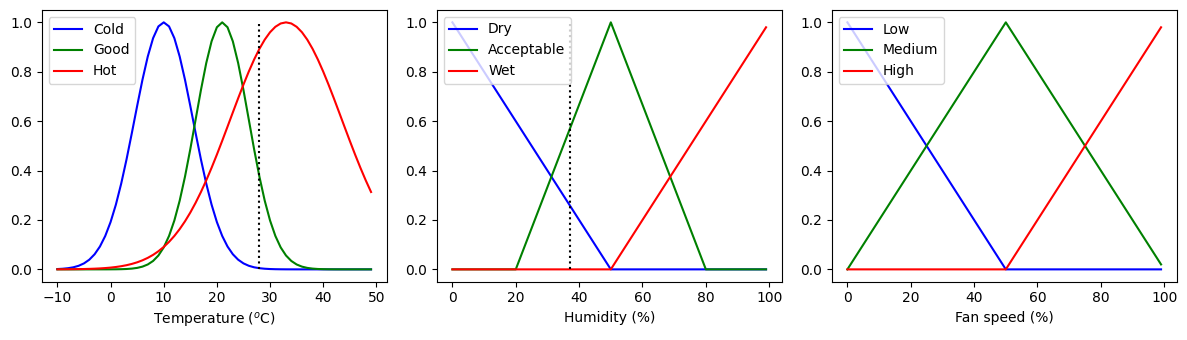

In [16]:
# Visualize these universes and membership functions

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 3.5))

ax0.plot(x_temp, temp_cold, 'b', linewidth=1.5, label='Cold')
ax0.plot(x_temp, temp_good, 'g', linewidth=1.5, label='Good')
ax0.plot(x_temp, temp_hot, 'r', linewidth=1.5, label='Hot')
ax0.plot([T, T], [0, 1], ':k')
ax0.set_xlabel('Temperature ($^o$C)')
ax0.legend(loc='upper left')

ax1.plot(x_humidity, humid_dry, 'b', linewidth=1.5, label='Dry')
ax1.plot(x_humidity, humid_acceptable, 'g', linewidth=1.5, label='Acceptable')
ax1.plot(x_humidity, humid_wet, 'r', linewidth=1.5, label='Wet')
ax1.plot([H, H], [0, 1], ':k')
ax1.set_xlabel('Humidity (%)')
ax1.legend(loc='upper left')

ax2.plot(x_fan, fan_lo, 'b', linewidth=1.5, label='Low')
ax2.plot(x_fan, fan_md, 'g', linewidth=1.5, label='Medium')
ax2.plot(x_fan, fan_hi, 'r', linewidth=1.5, label='High')
ax2.set_xlabel('Fan speed (%)')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

#### Find the membership values of the inputs ####

In [8]:
# We need the activation of our fuzzy membership functions at these values.
# The exact values T and H do not exist on our universes...
# This is what fuzz.interp_membership exists for! find the fuzzy value in each mem. func.
temp_level_lo = fuzz.interp_membership(x_temp, temp_cold, T)
temp_level_md = fuzz.interp_membership(x_temp, temp_good, T)
temp_level_hi = fuzz.interp_membership(x_temp, temp_hot, T)
print(f"I believe that temprature {T}[C] is : {temp_level_lo:.2f} 'cold' , {temp_level_md:.2f} 'good', {temp_level_hi:.2f} 'high'")

humid_level_lo = fuzz.interp_membership(x_humidity, humid_dry, H)
humid_level_md = fuzz.interp_membership(x_humidity, humid_acceptable, H)
humid_level_hi = fuzz.interp_membership(x_humidity, humid_wet, H)
print(f"I believe that humidity {H}[%] is : {humid_level_lo:.2f} 'dry' , {humid_level_md:.2f} 'acceptable', {humid_level_hi} 'wet'")

I believe that temprature 28[C] is : 0.00 'cold' , 0.38 'good', 0.74 'high'
I believe that humidity 37[%] is : 0.26 'dry' , 0.57 'acceptable', 0.0 'wet'


####  Define and calculate the fuzzy rules ####

##### Rule #1  #####

If the Temperature is Hot **AND** Humidity is Wet, then the fan is High

0.0 will be projected over 'High' set of the fan speed


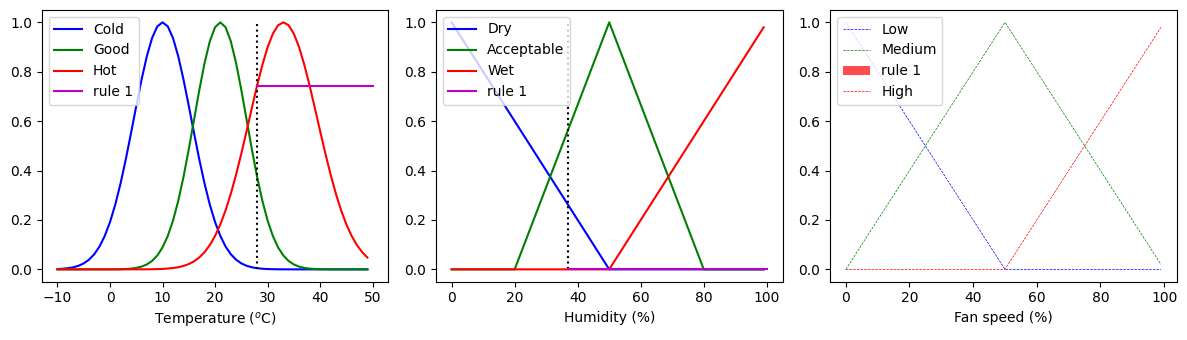

In [9]:
# The AND operator means we take the minimum of these two.
alpha1 = np.fmin(temp_level_hi, humid_level_hi)

# Now we apply this by clipping the top off the corresponding output
# membership function with `np.fmin`
# This finds the top of the fuzzy patch for high fan
fan_activation_hi = np.fmin(alpha1, fan_hi)  # removed entirely to 0

print(f"{alpha1} will be projected over 'High' set of the fan speed")

# Visualize this
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 3.5))
fan0 = np.zeros_like(x_fan)

ax0.plot(x_temp, temp_cold, 'b', linewidth=1.5, label='Cold')
ax0.plot(x_temp, temp_good, 'g', linewidth=1.5, label='Good')
ax0.plot(x_temp, temp_hot, 'r', linewidth=1.5, label='Hot')
ax0.plot([T, T], [0, 1], ':k')
ax0.plot([T, 50], [temp_level_hi, temp_level_hi], '-m', label = 'rule 1')
ax0.set_xlabel('Temperature ($^o$C)')
ax0.legend(loc='upper left')

ax1.plot(x_humidity, humid_dry, 'b', linewidth=1.5, label='Dry')
ax1.plot(x_humidity, humid_acceptable, 'g', linewidth=1.5, label='Acceptable')
ax1.plot(x_humidity, humid_wet, 'r', linewidth=1.5, label='Wet')
ax1.plot([H, H], [0, 1], ':k')
ax1.plot([H, 100], [humid_level_hi, humid_level_hi], '-m', label = 'rule 1')
ax1.set_xlabel('Humidity (%)')
ax1.legend(loc='upper left')

ax2.plot(x_fan, fan_lo, 'b', linewidth=0.5, linestyle='--', label='Low')
ax2.plot(x_fan, fan_md, 'g', linewidth=0.5, linestyle='--', label='Medium')#, marker = '.')
ax2.fill_between(x_fan, fan0, fan_activation_hi, facecolor='r', alpha=0.7, label='rule 1')
ax2.plot(x_fan, fan_hi, 'r', linewidth=0.5, linestyle='--', label='High')
ax2.set_xlabel('Fan speed (%)')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

##### Rule #2  #####

If the Humidity is Acceptable, then the fan is Medium

0.57 will be projected over 'Medium' set of the fan speed


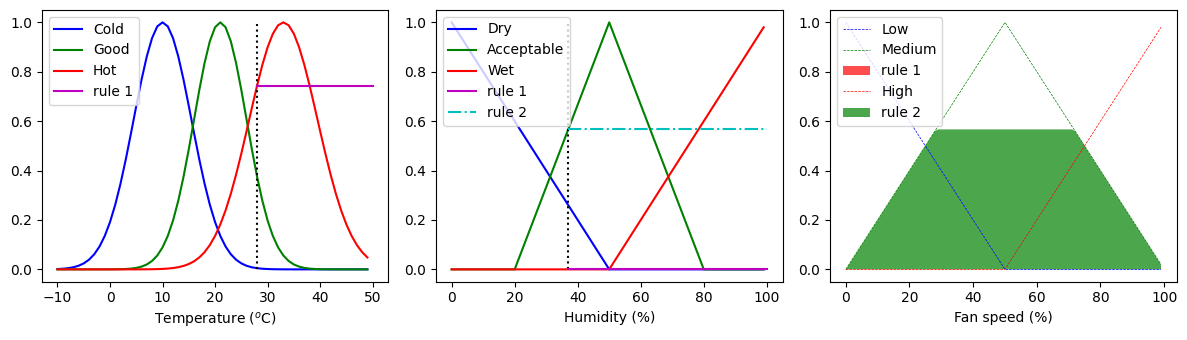

In [10]:
# One condition - no need of logic operator
alpha2 = humid_level_md

# Now we apply this by clipping the top off the corresponding output
# membership function with `np.fmin`
# This finds the top of the fuzzy patch for medium fan
fan_activation_md = np.fmin(alpha2, fan_md)

print(f"{alpha2:.2f} will be projected over 'Medium' set of the fan speed")

# Visualize this
# This rule takes just the humidity level so we dont need to use ax0
fig.gca()
ax1.plot([H, 100], [humid_level_md, humid_level_md], '-.c', label = 'rule 2')
ax1.legend(loc='upper left')

ax2.fill_between(x_fan, fan0, fan_activation_md, facecolor='g', alpha=0.7, label='rule 2')
ax2.legend(loc='upper left')

fig

##### Rule #3  #####

If the Temperature is Good **OR** the Humidity is Dry, then the fan will be Low

0.38 will be projected over 'Low' set of the fan speed


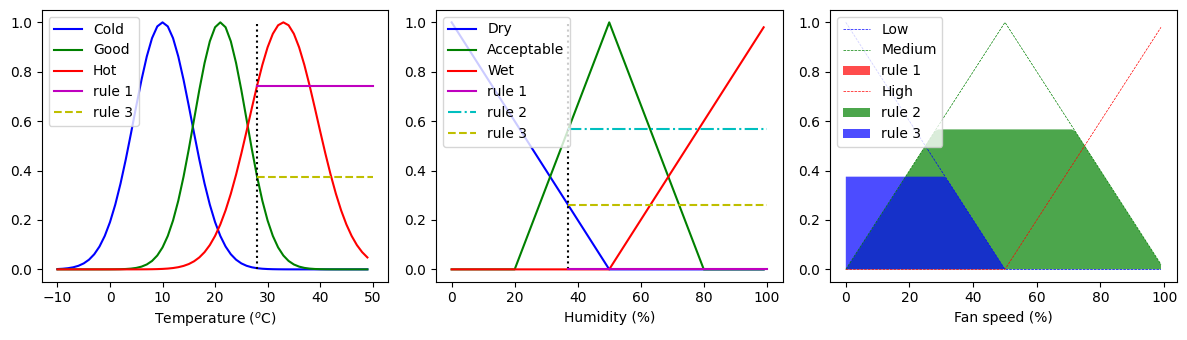

In [11]:
# The OR operator means we take the maximum of these two.
alpha3 = np.fmax(temp_level_md, humid_level_lo)

# Now we apply this by clipping the top off the corresponding output
# membership function with `np.fmin`
# This finds the top of the fuzzy patch for low fan
fan_activation_lo = np.fmin(alpha3, fan_lo)

print(f"{alpha3:.2f} will be projected over 'Low' set of the fan speed")

# Visualize this
fig.gca()
ax0.plot([T, 50], [temp_level_md, temp_level_md], '--y', label = 'rule 3')
ax0.legend(loc='upper left')

ax1.plot([H, 100], [humid_level_lo, humid_level_lo], '--y', label = 'rule 3')
ax1.legend(loc='upper left')

ax2.fill_between(x_fan, fan0, fan_activation_lo, facecolor='b', alpha=0.7, label='rule 3')
ax2.legend(loc='upper left')

fig

##### Aggregate rules output #####

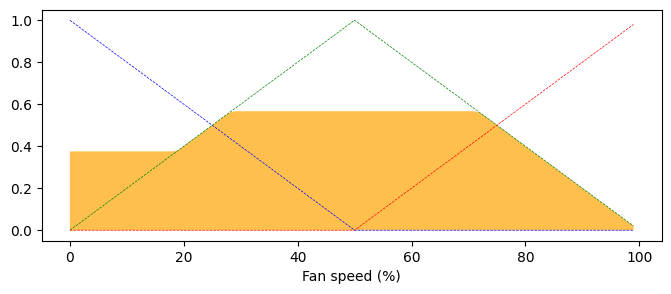

In [12]:
# Aggregate all three output membership functions together
beta = np.fmax(fan_activation_lo,
                     np.fmax(fan_activation_md, fan_activation_hi))

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.plot(x_fan, fan_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.plot(x_fan, fan_md, 'g', linewidth=0.5, linestyle='--')
ax0.plot(x_fan, fan_hi, 'r', linewidth=0.5, linestyle='--')
ax0.fill_between(x_fan, fan0, beta, facecolor='Orange', alpha=0.7)
ax0.set_xlabel('Fan speed (%)')

plt.show()

##### Defuzzification #####

In [13]:
# Calculate defuzzified result
fan_cog = fuzz.defuzz(x_fan, beta, 'centroid')
fan_mom = fuzz.defuzz(x_fan, beta, 'mom')
fan_som = fuzz.defuzz(x_fan, beta, 'som')
fan_lom = fuzz.defuzz(x_fan, beta, 'lom')
fan_cog_activation = fuzz.interp_membership(x_fan, beta, fan_cog)  # for plot
fan_mom_activation = fuzz.interp_membership(x_fan, beta, fan_mom)  # for plot
fan_som_activation = fuzz.interp_membership(x_fan, beta, fan_som)  # for plot
fan_lom_activation = fuzz.interp_membership(x_fan, beta, fan_lom)  # for plot

print(f"{fan_cog:.2f}[%] of the fan speed - centroid result")
print(f"{fan_mom:.2f}[%] of the fan speed - mean of max result")
print(f"{fan_som:.2f}[%] of the fan speed - small of max result")
print(f"{fan_lom:.2f}[%] of the fan speed - large of max result")

46.50[%] of the fan speed - centroid result
50.00[%] of the fan speed - mean of max result
29.00[%] of the fan speed - small of max result
71.00[%] of the fan speed - large of max result


##### Visualize fuzzy output #####

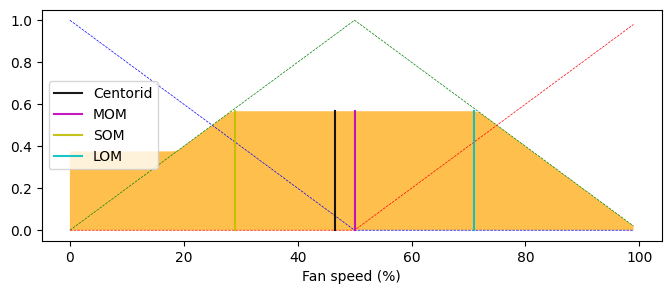

In [14]:
# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.plot(x_fan, fan_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.plot(x_fan, fan_md, 'g', linewidth=0.5, linestyle='--')
ax0.plot(x_fan, fan_hi, 'r', linewidth=0.5, linestyle='--')
ax0.fill_between(x_fan, fan0, beta, facecolor='Orange', alpha=0.7)
ax0.plot([fan_cog, fan_cog], [0, fan_cog_activation], 'k', linewidth=1.5, alpha=0.9, label = 'Centorid')
ax0.plot([fan_mom, fan_mom], [0, fan_mom_activation], 'm', linewidth=1.5, alpha=0.9, label = 'MOM')
ax0.plot([fan_som, fan_som], [0, fan_som_activation], 'y', linewidth=1.5, alpha=0.9, label = 'SOM')
ax0.plot([fan_lom, fan_lom], [0, fan_lom_activation], 'c', linewidth=1.5, alpha=0.9, label = 'LOM')
ax0.set_xlabel('Fan speed (%)')
ax0.legend()

plt.show()

----------

## Summary ##

In this class we covered:

1. An overview of fuzzy control systems (briefly).
2. Designing a fuzzy control system for regulating fan speed using a fuzzy inference system based on three rules with multiple conditions.
3. Implementing the control system and visualizing the rules and final output using Python's skfuzzy library.

---


## Helpful and extra links ##

1. [Fuzzy control system using python skfuzzy example - 'The Tipping Problem'](https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_tipping_problem.html) 
2. [Fuzzy control systems - explained](https://www.youtube.com/watch?v=R9eN9CIkwxc)
---